# Construct hierarchy from Seurat clustering for t3 dataset

In [131]:
suppressMessages({
    source('../../R/gene_signature.R')
    library(tidyverse)
})

Warning message:
“package ‘limma’ was built under R version 3.5.1”

## load the dataset and tidy the dataset

In [3]:
t3_scaled_matrix.path = "../../data/scaledData/t3.scaledexpression.cutree.csv"
#t4_scaled_matrix.path = "../../data/scaledData/t4.scaledexpression.cutree.csv"
t3_clusters.path = "../../data/DESeq/t3.Seurat.cluster.csv"
#t4_clusters.path = "../../data/DESeq/t4.Seurat.cluster.csv"

In [194]:
t3_count_matrix.path = '../../data/DESeq/t_3k_genesymbol.csv'

In [9]:
suppressMessages({
    t3_clusters = read_csv(t3_clusters.path)
})
colnames(t3_clusters)[1] = 'cell'

Warning message:
“Missing column names filled in: 'X1' [1]”

In [10]:
head(t3_clusters, n=2)

cell,nGene,nUMI,orig.ident,sample,percent.mito,percent.rpl,percent.rps,res.0.6,res.0.1,res.0.2,res.0.3,res.0.4,res.0.5,res.0.7,res.0.8,res.0.9,res.1
AAACCTGGTAAATACG-1,1121,4572,t3,t3,0.04593176,0.3027122,0.2117235,0,0,1,0,0,0,0,0,0,0
AAACCTGGTGTGCCTG-1,1076,3952,t3,t3,0.03390688,0.2887146,0.2315283,5,1,3,4,5,5,4,4,4,4


In [22]:
suppressMessages({
    t3_scaled_matrix = read.table(t3_scaled_matrix.path, header=T, row.names = 1)
})

In [28]:
head(t3_scaled_matrix_cleaned[1:4, 1:4])

,TSPAN6,TNMD,DPM1,SCYL3
AAACCTGGTAAATACG-1,-0.06760678,0,-0.401611,-0.1581129
AAACCTGGTGTGCCTG-1,-0.06760678,0,-0.401611,-0.1581129
AAACCTGTCAGCTCTC-1,-0.06760678,0,-0.401611,-0.1581129
AAACGGGAGGGCTTGA-1,-0.06760678,0,2.363806,-0.1581129


In [24]:
t3_scaled_matrix_cleaned = t3_scaled_matrix[, -(ncol(t3_scaled_matrix) - (0:3))]

In [27]:
rownames(t3_scaled_matrix_cleaned) = gsub('\\.', '-', rownames(t3_scaled_matrix_cleaned))

In [195]:
t3_count_matrix = read.table(t3_count_matrix.path, header=1, row.names=1)

In [198]:
t3_count_matrix_cleaned = t3_count_matrix

In [200]:
colnames(t3_count_matrix_cleaned) = gsub('\\.', '-', colnames(t3_count_matrix_cleaned))

In [202]:
t3_count_matrix_cleaned = t(t3_count_matrix_cleaned)

## Compute the average per gene within each cluster

In [34]:
membership = select(t3_clusters, cell, res.0.6)
colnames(membership) = c('cell', 'membership')
cluster_numbers = unique(membership$membership)

In [40]:
cluster_numbers

[1] 0 5 3 1 2 4

In [45]:
clusters_average = c()
for (cluster in cluster_numbers) {
    cells_id_in_cluster = membership %>%
      filter(membership == cluster) %>%
      select(cell) %>% unlist
    #print(cells_id_in_cluster[1:2])
    #print(head(cells_id_in_cluster))
    cluster_scaled_matrix = t3_scaled_matrix_cleaned[cells_id_in_cluster,]
    #print(cluster_scaled_matrix[1:5, 1:5])
    cluster_average = apply(cluster_scaled_matrix, 2, mean)
    clusters_average = rbind(clusters_average, cluster_average)
}

In [46]:
rownames(clusters_average) = cluster_numbers

In [47]:
clusters_average[,1:10] # cluster-wise gene average

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA
0,-0.01591175,0,0.019528824,-0.07315309,-0.026116968,-0.1110114,0.11168856,0.05220702,-0.069012834,-0.038871280
5,-0.04328889,0,-0.032824422,0.03327807,-0.014822901,-0.1427894,-0.10321316,-0.08197279,0.066457080,-0.001641080
3,0.05442482,0,0.002287752,-0.04244132,0.030626133,-0.1427894,-0.10321316,-0.04664824,-0.027996835,0.005598681
1,-0.02791845,0,0.024424651,0.03417914,-0.021643090,-0.1427894,-0.09283028,-0.08021705,-0.019302261,0.073000832
2,-0.04828316,0,-0.065903213,0.08686592,-0.014316430,-0.1098433,0.04194908,0.06096715,0.007752411,-0.034987134
4,-0.04718567,0,0.026353619,-0.01429997,-0.006074518,0.7728175,0.07822808,0.08874942,0.099232654,-0.018532554


## Create the hclust on the cluster average

In [49]:
dist_clusters = dist(clusters_average)

In [57]:
hclust_obj = hclust(dist_clusters, method='ward.D2')

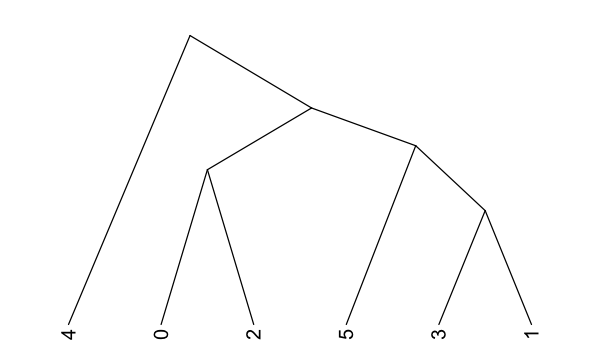

In [80]:
options(repr.plot.width = 5, repr.plot.height = 3)
par(oma=c(0,0,0,0),mar=c(1,0,1,0))
plot(as.dendrogram(hclust_obj), type = "triangle", ylab = "Distance", axes=F)

In [82]:
pdf('../../figures/dendrogram_seurat_res_0_6.pdf', width=5, height=3)
par(oma=c(0,0,0,0),mar=c(1,1,1,1))
plot(as.dendrogram(hclust_obj), type = "triangle", ylab = "Distance", axes=F)
dev.off()

pdf 
  2

## Create the hierarchy matrix to be used in running the differentially expressed genes 

In [96]:
K = seq(2, length(cluster_numbers))

In [99]:
memberships = c()
for (k in K) {
    membership_k = cutree(hclust_obj, k=k)
    names(membership_k) = NULL
    #print(k)
    #print(membership_k)
    memberships = cbind(memberships, membership_k)
}

In [102]:
rownames(memberships) = cluster_numbers
colnames(memberships) = K

In [103]:
memberships # each row represent a cluster and each column represent a cut that produces the given number of clusters

,2,3,4,5,6
0,1,1,1,1,1
5,1,2,2,2,2
3,1,2,3,3,3
1,1,2,3,3,4
2,1,1,1,4,5
4,2,3,4,5,6


## Expand the hierarchy matrix for the cells

- For each cell (row names) in the original expression matrix (`t3_scaled_matrix_cleaned`), 
  - find which cluster they belong to from the cluster identity matrix (`membership`)
  - append the corresponding rows from `membership` to create the ancestor matrix for all cells
- save the cell ancestor matrix as a csv.

In [104]:
cells_id = rownames(t3_scaled_matrix_cleaned)

In [128]:
cell_ancestor_matrix = c()
cell_memberships = c()
for (cell in cells_id) {
    #print(cell)
    cell_membership = membership[membership[,1] == cell, 2] %>% as.character
    cell_memberships = c(cell_memberships, cell_membership)
    #print(cell_membership)
    cell_ancestor_matrix = rbind(cell_ancestor_matrix, memberships[cell_membership,])
}
#print(cell_ancestor_matrix)
rownames(cell_ancestor_matrix) = cells_id

In [129]:
cell_ancestor_matrix[1:5, 1:5]

,2,3,4,5,6
AAACCTGGTAAATACG-1,1,1,1,1,1
AAACCTGGTGTGCCTG-1,1,2,2,2,2
AAACCTGTCAGCTCTC-1,1,2,3,3,3
AAACGGGAGGGCTTGA-1,1,2,3,3,4
AAACGGGAGTATCGAA-1,1,2,3,3,4


In [130]:
write.csv(cell_ancestor_matrix, file='../../data/treeHierarchy/cell_ancestor_matrix.csv')

## Run the differentially expressed genes by traversing each level

goal: return a data frame that defines the DE for clusters (cluster_df)
- For each level of the hierarchy (where there will be exactly one cut occuring), find out the subset where the cut occurs
  - subset the set of split where it occurs
  - compute the DE for each node and get the genes
  - define the cluster_id and genes as a data frame
  - write the information into the `cluster_DE`

In [172]:
q_thresh = 0.2
FC_thresh = 1.0

In [158]:
head(expression[1:4, 1:5])

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112
AAACCTGGTAAATACG-1,-0.06760678,0,-0.401611,-0.1581129,-0.0879238
AAACCTGGTGTGCCTG-1,-0.06760678,0,-0.401611,-0.1581129,-0.0879238
AAACCTGTCAGCTCTC-1,-0.06760678,0,-0.401611,-0.1581129,-0.0879238
AAACGGGAGGGCTTGA-1,-0.06760678,0,2.363806,-0.1581129,-0.0879238


In [173]:
cluster_DE = c()
for (k in seq(ncol(cell_ancestor_matrix))[1:2]) {
   print(k)
   if (k == 1) {
       unique_clusters = unique(cell_ancestor_matrix[,k])
       expression = t3_scaled_matrix_cleaned
       for (unique_cluster in unique_clusters) {
           unique_cluster_membership = (cell_ancestor_matrix[,k] == unique_cluster)
           over = OverExpressedGenes(unique_cluster_membership, t(expression), q_thresh, FC_thresh)
           subtree_id = paste(data.matrix(cell_ancestor_matrix[which(unique_cluster_membership)[1], seq(k)]), collapse='_')
           print(paste(subtree_id, length(over)))
           if (length(over) > 0) {
               cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=over))
           } else {
               cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=NA))
           }
       }
   } else {
       # find where the split occurs
    summary_matrix = table(cell_ancestor_matrix[,k-1], cell_ancestor_matrix[,k])
    parent_split_idx = apply(summary_matrix, 1, function(x) sum(x > 0) == 2)
    parent_split = names(parent_split_idx)[parent_split_idx]            
    # subset for the part expression matrix of the expression matrix at level k - 1 where it
    subset_idx = cell_ancestor_matrix[,k-1] == parent_split
    expression = t3_scaled_matrix_cleaned[subset_idx, ]
    cell_ancestor_matrix_subset = cell_ancestor_matrix[subset_idx,]
    unique_clusters = unique(cell_ancestor_matrix_subset[,k])
    for (unique_cluster in unique_clusters) {
           unique_cluster_membership = (cell_ancestor_matrix_subset[,k] == unique_cluster)
           over = OverExpressedGenes(unique_cluster_membership, t(expression), q_thresh, FC_thresh)
           subtree_id = paste(data.matrix(cell_ancestor_matrix_subset[which(unique_cluster_membership)[1], seq(k)]), collapse='_')
           print(paste(subtree_id, length(over)))
            if (length(over) > 0) {
               cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=over))
           } else {
               cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=NA))
           }
       }
   }
}

[1] 1


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1 35"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "2 13"
[1] 2


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_1 0"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_2 0"


In [176]:
summary(cluster_DE)

   id             gene   
 1  :35   AC005838.2: 1  
 2  :13   AL662797.1: 1  
 1_1: 1   ATXN7L1   : 1  
 1_2: 1   BICD2     : 1  
          C12orf4   : 1  
          (Other)   :43  
          NA's      : 2  

In [178]:
head(cluster_DE)
tail(cluster_DE)

id,gene
1,ZMYM3
1,TRAV8.2
1,ITPR1
1,AL662797.1
1,MACF1
1,CACNA1C.AS2


,id,gene
45,2,NFKBIA
46,2,PDPR
47,2,TRAF4
48,2,PSMA4
49,1_1,NA
50,1_2,NA


In [204]:
#' @param cell_ancestor_matrix n cells by k levels matrix
#' @param expression_matrix n cells by m genes matrix
#' @return return a list of the (cluster_id, genes) pairs that are overexpressed in the cluster against 
#' its sibling
 
DE_hclust = function(cell_ancestor_matrix, expression_matrix, FC_thresh=1.0, q_thresh=0.2) {
    cluster_DE = c()
    for (k in seq(ncol(cell_ancestor_matrix))) {
       print(k)
       if (k == 1) {
           unique_clusters = unique(cell_ancestor_matrix[,k])
           expression = expression_matrix
           for (unique_cluster in unique_clusters) {
               unique_cluster_membership = (cell_ancestor_matrix[,k] == unique_cluster)
               over = OverExpressedGenes(unique_cluster_membership, t(expression), q_thresh, FC_thresh)
               subtree_id = paste(data.matrix(cell_ancestor_matrix[which(unique_cluster_membership)[1], seq(k)]), collapse='_')
               print(paste(subtree_id, length(over)))
               if (length(over) > 0) {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=over))
               } else {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=NA))
               }
           }
       } else {
       # find where the split occurs
        summary_matrix = table(cell_ancestor_matrix[,k-1], cell_ancestor_matrix[,k])
        parent_split_idx = apply(summary_matrix, 1, function(x) sum(x > 0) == 2)
        parent_split = names(parent_split_idx)[parent_split_idx]            
        # subset for the part expression matrix of the expression matrix at level k - 1 where it
        subset_idx = cell_ancestor_matrix[,k-1] == parent_split
        expression = expression_matrix[subset_idx, ]
        cell_ancestor_matrix_subset = cell_ancestor_matrix[subset_idx,]
        unique_clusters = unique(cell_ancestor_matrix_subset[,k])
        for (unique_cluster in unique_clusters) {
               unique_cluster_membership = (cell_ancestor_matrix_subset[,k] == unique_cluster)
               over = OverExpressedGenes(unique_cluster_membership, t(expression), q_thresh, FC_thresh)
               subtree_id = paste(data.matrix(cell_ancestor_matrix_subset[which(unique_cluster_membership)[1], seq(k)]), collapse='_')
               print(paste(subtree_id, length(over)))   
               if (length(over) > 0) {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=over))
               } else {
                   cluster_DE = rbind(cluster_DE, data.frame(id = subtree_id, gene=NA))
               }
           }
       }
    }
    return(cluster_DE)
}

In [174]:
head(cell_ancestor_matrix[1:4, 1:4])

,2,3,4,5
AAACCTGGTAAATACG-1,1,1,1,1
AAACCTGGTGTGCCTG-1,1,2,2,2
AAACCTGTCAGCTCTC-1,1,2,3,3
AAACGGGAGGGCTTGA-1,1,2,3,3


In [175]:
head(t3_scaled_matrix_cleaned[1:4, 1:4])

,TSPAN6,TNMD,DPM1,SCYL3
AAACCTGGTAAATACG-1,-0.06760678,0,-0.401611,-0.1581129
AAACCTGGTGTGCCTG-1,-0.06760678,0,-0.401611,-0.1581129
AAACCTGTCAGCTCTC-1,-0.06760678,0,-0.401611,-0.1581129
AAACGGGAGGGCTTGA-1,-0.06760678,0,2.363806,-0.1581129


In [183]:
cluster_genes_DE = DE_hclust(cell_ancestor_matrix, t3_scaled_matrix_cleaned)

[1] 1


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1 35"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "2 13"
[1] 2


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_1 0"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_2 0"
[1] 3


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_2_2 39"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_2_3 6"
[1] 4


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_1_1_1 0"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_1_1_4 0"
[1] 5


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_2_3_3_3 0"


Warning message:
“Zero sample variances detected, have been offset away from zero”

[1] "1_2_3_3_4 5"


In [205]:
sum(rownames(t3_count_matrix_cleaned) != rownames(cell_ancestor_matrix))

Warning message in rownames(t3_count_matrix_cleaned) != rownames(cell_ancestor_matrix):
“longer object length is not a multiple of shorter object length”

[1] 3537

In [208]:
dim(t3_count_matrix_cleaned_subset)

[1]  3463 33202

In [209]:
dim(cell_ancestor_matrix)

[1] 3463    5

In [207]:
t3_count_matrix_cleaned_subset = t3_count_matrix_cleaned[rownames(cell_ancestor_matrix),]

In [257]:
FC_thresh = 1.1
q_thresh = 0.2
cluster_genes_DE = DE_hclust(cell_ancestor_matrix[,1:2], t3_count_matrix_cleaned_subset, FC_thresh=FC_thresh, 
                            q_thresh = q_thresh)

In [255]:
cluster_genes_DE

NULL

## Compute the differential expression on the lowest level

In [213]:
t3_count_matrix[1:2, 1:2]

,AAACCTGGTAAATACG.1,AAACCTGGTGTGCCTG.1
TSPAN6,0,0
TNMD,0,0


In [217]:
expression_test = expression[1,] %>% unlist
label = sample(c(T, F), length(expression_test), replace=T)

In [219]:
res = wilcox.test(expression_test~label)

In [220]:
res$statistic

W 
137930454

In [222]:
res$

NULL

In [223]:
library(qvalue)

In [252]:
source('../../R/gene_signature.R')

In [228]:
X = matrix(runif(500), ncol=10, nrow=50)
colnames(X) = paste0('c', seq(ncol(X)))
rownames(X) = paste0('gene', seq(nrow(X)))

In [229]:
head(X)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
gene1,0.4709134,0.02212056,0.1702942,0.5523604,0.5621843,0.75394619,0.7414310,0.14958865,0.62169504,0.4018733
gene2,0.7477297,0.30555776,0.8516359,0.2992713,0.2881458,0.02346765,0.1508080,0.96719501,0.34150410,0.3606569
gene3,0.2429081,0.43067152,0.9708850,0.8756577,0.4409997,0.85591459,0.1096288,0.46049656,0.76458948,0.5600314
gene4,0.8933219,0.83846398,0.5343653,0.9653373,0.3929991,0.90857779,0.9880657,0.07509679,0.47918571,0.4069844
gene5,0.2705880,0.32632071,0.2202370,0.1955326,0.8555964,0.89363079,0.9403148,0.61186933,0.39333725,0.1557477
gene6,0.7512884,0.62438513,0.3668668,0.3905545,0.3929433,0.05872827,0.3150376,0.31758449,0.09308752,0.6057863


In [233]:
child_node_1_idx = sample(c(T, F), ncol(X), replace=T)

In [234]:
sum(child_node_1_idx)

[1] 6

In [251]:
DE_childrenNodes.wilcox(X, child_node_1_idx, !child_node_1_idx, 
                       q_thresh = 0.99, FC_thresh = 1)

,logFC,p.value,q.value
gene42,0.4343282,0.06666667,0.8333333


## Naive DE

In [260]:
bottom_level_membership = cell_ancestor_matrix[, 5]

In [261]:
head(bottom_level_membership)

AAACCTGGTAAATACG-1 AAACCTGGTGTGCCTG-1 AAACCTGTCAGCTCTC-1 AAACGGGAGGGCTTGA-1 
                 1                  2                  3                  4 
AAACGGGAGTATCGAA-1 AAACGGGCAGTTCCCT-1 
                 4                  5

In [262]:
cluster = 1
is_cluster_1 = (bottom_level_membership == cluster)

In [263]:
t3_count_matrix_cleaned_subset %>% dim

[1]  3463 33202

In [ ]:
length(bottom_level)